# Format annotations

#### Importing libraries and defining functions

In [1]:
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
def getImageInfo(images, image_id):
    """
    DESCRIPTION:
        Extracts width and height and fileName for a given image ID.
    
    INPUTS:
    - images (list): List of image metadata dictionaries.
    - image_id (int): The image ID to search for.
    
    OUTPUTS:
    - (width, height, fileName) tuple if found, else None
    """
    for img in images:
        if img["id"] == image_id:
            return img["width"], img["height"], img["file_name"]
    return None  # Return None if ID not found


def plotBwImage(image_matrix):
    """
    DESCRIPTION:
        Plots a black-and-white image stored as a matrix (2D numpy array).
    
    INPUTS:
    - image_matrix (numpy.ndarray): A 2D array representing the BW image.

    OUTPUT:
    - None: a figure is instantiated
    """
    
    alpha_channel = np.where(image_matrix == 0, 0, 150)  # 0 for black, 150 for non-black
    alpha_channel = alpha_channel.astype(np.uint8)
    #print(np.unique(alpha_channel))
    
    # Make sure the alpha channel is in the correct range [0, 1]
    zeros = np.zeros(shape=image_matrix.shape).astype(np.uint8)
    rgba_image = np.dstack((image_matrix, zeros, zeros, alpha_channel))

    plt.imshow(rgba_image)
    plt.axis('off')  # Optional: Hide axis for a cleaner view


def plotImageFromPath(image_path):
    """
    Opens and plots an image using the file path provided.
    
    Args:
    - image_path (str): The path to the image file.
    """
    # Step 1: Read the image from the given file path using OpenCV
    image = cv2.imread(image_path)
    
    if image is None:
        print(f"Error: Unable to load image at {image_path}")
        return

    # Step 2: Convert the image from BGR (OpenCV default) to RGB (matplotlib format)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Step 3: Plot the image using matplotlib
    plt.imshow(image_rgb)
    plt.axis('off')  # Hide the axes
    #plt.show()

#### Importing the dataset

In [3]:
dataset = ["Train", "Validation"]
dataset = dataset[0]

print(f"You selected the {dataset} dataset")

You selected the Train dataset


In [4]:
# Load the COCO annotation file
with open(f"{dataset}/_annotations.coco.json", "r") as f:
    coco_data = json.load(f)

In [5]:
coco_data["annotations"][0].keys()

dict_keys(['iscrowd', 'image_id', 'bbox', 'segmentation', 'category_id', 'id', 'area'])

#### Merging annotations by image ID

In [6]:
# Initialize a dictionary to hold the merged annotations by image_id
annotations_by_image = {}

# Loop through the annotations and group by image_id
for i in range(len(coco_data["annotations"])):
    annotation = coco_data["annotations"][i]
    
    # Retrieve necessary information
    segmentation = annotation["segmentation"]
    imageID = annotation["image_id"]
    categoryID = annotation["category_id"]
    width, height, fileName = getImageInfo(coco_data["images"], imageID)
    
    # Initialize mask if this image_id is encountered for the first time
    if imageID not in annotations_by_image:
        annotations_by_image[imageID] = {
            "segmentation": [],
            "mask": np.zeros((height, width), dtype=np.uint8),
            "fileName": fileName
        }

    # Handle multiple polygons in the segmentation
    if isinstance(segmentation[0], list):  # Multiple polygons
        for poly in segmentation:
            if len(poly) % 2 == 0:  # Ensure even-length (x, y pairs)
                polygon = np.array(poly, dtype=np.int32).reshape((-1, 2))  # Reshape to (N, 2)
                cv2.fillPoly(annotations_by_image[imageID]["mask"], [polygon], color=255)  # Add to the mask
    else:  # Single polygon
        if len(segmentation) % 2 == 0:  # Ensure even-length (x, y pairs)
            polygon = np.array(segmentation, dtype=np.int32).reshape((-1, 2))  # Reshape to (N, 2)
            cv2.fillPoly(annotations_by_image[imageID]["mask"], [polygon], color=255)  # Add to the mask

#### Exporting as a binary mask indicating the defect

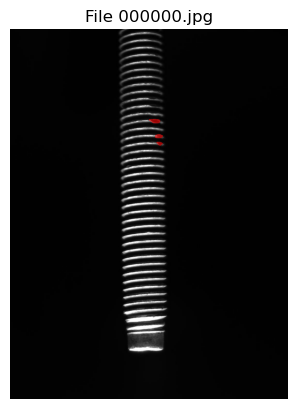

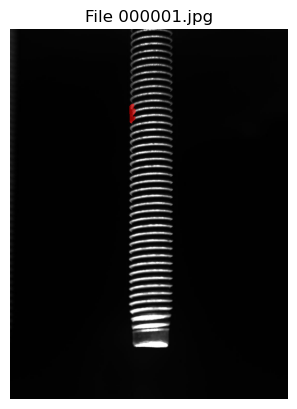

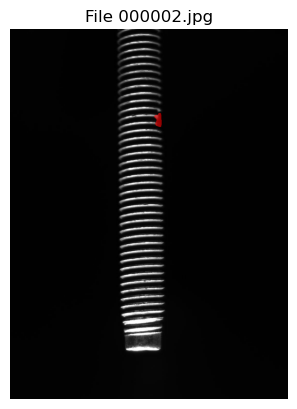

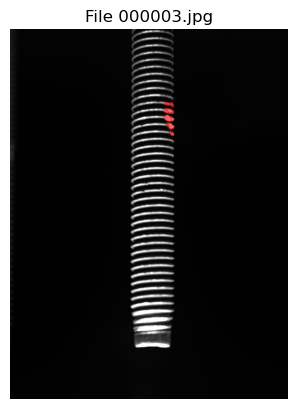

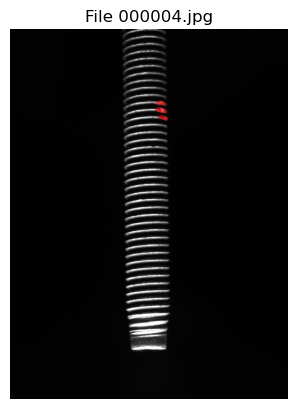

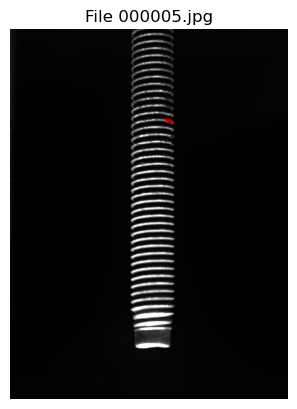

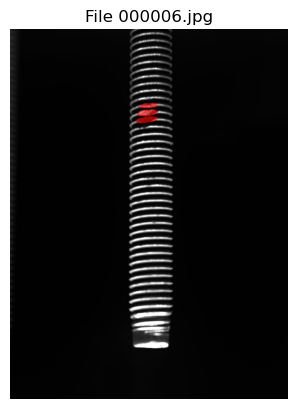

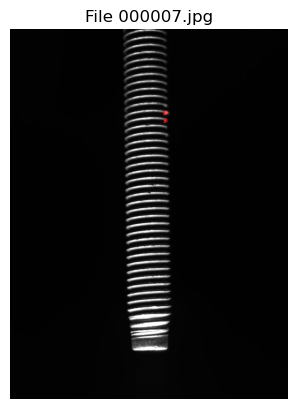

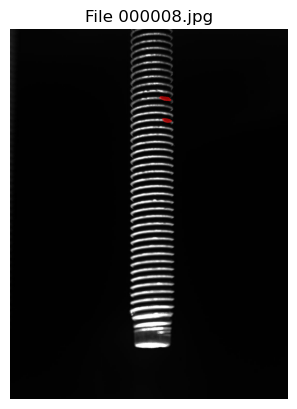

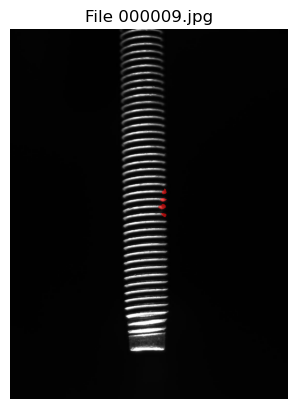

In [8]:
plotImages = True
nImagesToPlot = 10

saveMasks = False

i = 0
for imageID, data in annotations_by_image.items():

    mask = data["mask"]
    fileName = data["fileName"]
    
    # Convert mask to an image and display/save
    mask_img = Image.fromarray(mask)
    
    # Plot images if specified
    if plotImages and i < nImagesToPlot:
        plt.title(f"File {fileName}")
        plotImageFromPath(f"{dataset}/images/{fileName}")
        plotBwImage(mask)
        plt.show()

    # Save the mask image
    if saveMasks:
        mask_img.save(f"{dataset}/masks/{fileName[:-4]}.png")

    i+=1